In [1]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import load_img, img_to_array, to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
X_train = np.load("/content/drive/MyDrive/Proyecto Grado/images.npy")
y_train = np.load("/content/drive/MyDrive/Proyecto Grado/labels.npy")
print(X_train.shape, y_train.shape)

(14710, 224, 224, 3) (14710,)


In [4]:
n_clases = 5  # Las clases están en el rango de 1 a 5
num_imagenes_por_clase = 1000

# Crear una lista para almacenar las imágenes y las etiquetas seleccionadas
X_selected = []
y_selected = []

# Verificar cuántas imágenes tiene cada clase
for clase in range(1, n_clases + 1):
    # Obtener los índices de las imágenes correspondientes a la clase 'clase'
    indices = np.where(y_train == clase)[0]

    # Verificar si la clase tiene suficientes imágenes
    if len(indices) < num_imagenes_por_clase:
        raise ValueError(f"La clase {clase} no tiene suficientes imágenes (tiene {len(indices)} imágenes).")

    # Seleccionar 100 imágenes aleatorias de esa clase
    selected_indices = np.random.choice(indices, size=num_imagenes_por_clase, replace=False)

    # Añadir las imágenes y etiquetas seleccionadas a las listas
    X_selected.append(X_train[selected_indices])
    y_selected.append(y_train[selected_indices])

# Convertir las listas a arrays numpy
X_selected = np.concatenate(X_selected, axis=0)
y_selected = np.concatenate(y_selected, axis=0)

# Verifica el tamaño de los datos seleccionados
print("Número de imágenes seleccionadas:", X_selected.shape[0])
print("Primeras etiquetas seleccionadas:", y_selected[:10])

Número de imágenes seleccionadas: 5000
Primeras etiquetas seleccionadas: [1 1 1 1 1 1 1 1 1 1]


# Resnet



In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.2, random_state=42, stratify=y_selected)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

# Ahora tus datos están listos para ser utilizados con ResNet
print(f"Tamaño de X_train: {X_train.shape}, Tipo: {X_train.dtype}")
print(f"Tamaño de X_test: {X_test.shape}, Tipo: {X_test.dtype}")

Tamaño de X_train: (4000, 224, 224, 3), Tipo: float32
Tamaño de X_test: (1000, 224, 224, 3), Tipo: float32


In [6]:
y_train = y_train - 1
y_train = tf.keras.utils.to_categorical(y_train)
y_test = y_test - 1
y_test = tf.keras.utils.to_categorical(y_test)

In [7]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

model1 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same', kernel_initializer='he_uniform'),
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same', kernel_initializer='he_uniform'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same', kernel_initializer='he_uniform'),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same', kernel_initializer='he_uniform'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu', padding='same', kernel_initializer='he_uniform'),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu', padding='same', kernel_initializer='he_uniform'),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
    # tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    # tf.keras.layers.GlobalAveragePooling2D(),
    # tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dense(5, activation='softmax')
])

model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 7, 7, 32)            │       1,638,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 32)            │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 64)            │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 3, 64)            │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 1, 1, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 1, 1, 128)           │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,028,741 (99.29 MB)

 Trainable params: 2,441,029 (9.31 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 11.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


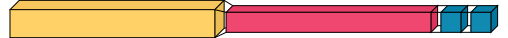

In [ ]:
import visualkeras
visualkeras.layered_view(model1)

In [8]:
callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, verbose = 1)
callback_reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
callbacks = [callback_es, callback_reduce_lr]

In [9]:
# Fit the model
history = model1.fit(X_train, y_train, epochs=20,verbose=1, batch_size=32,validation_data=(X_test, y_test), callbacks=[callbacks])

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 188ms/step - accuracy: 0.4400 - loss: 1.8396 - val_accuracy: 0.5930 - val_loss: 1.1081 - learning_rate: 0.0010
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.5915 - loss: 1.0953 - val_accuracy: 0.5800 - val_loss: 0.9970 - learning_rate: 0.0010
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.6529 - loss: 0.8909 - val_accuracy: 0.6730 - val_loss: 0.8795 - learning_rate: 0.0010
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.7039 - loss: 0.7655 - val_accuracy: 0.6890 - val_loss: 0.7829 - learning_rate: 0.0010
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 132ms/step - accuracy: 0.7496 - loss: 0.6741 - val_accuracy: 0.6730 - val_loss: 0.7458 - learning_rate: 0.0010
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.7791 - loss: 0.5733 - val_accuracy: 0.6230 - val_loss: 0.8495 - learning_rate: 0.0010
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.782

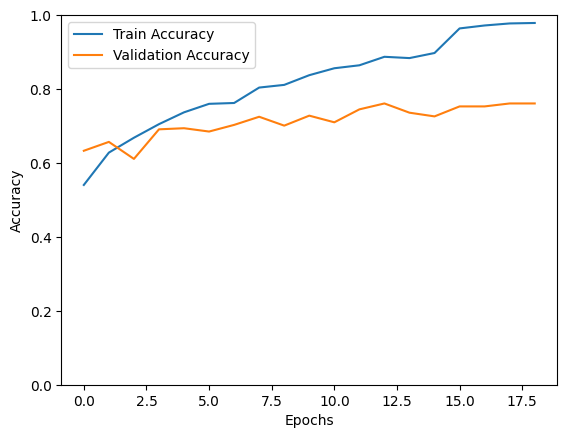

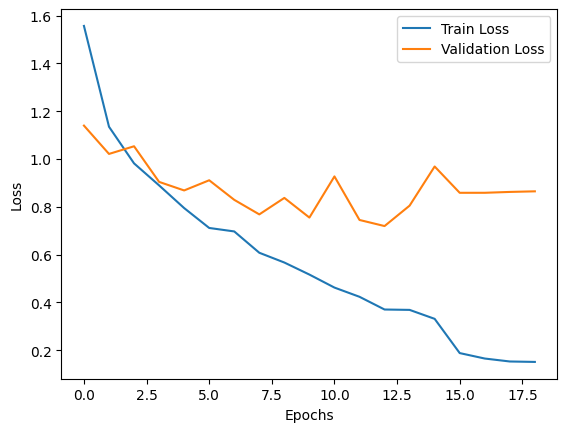

In [11]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)
plt.show()

# Graficar la pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
base_model.trainable = True

for layer in base_model.layers[:-50]:
    layer.trainable = False

model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model1.fit(X_train, y_train, epochs=15,verbose=1, batch_size=32,validation_data=(X_test, y_test), callbacks=[callbacks])

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 261ms/step - accuracy: 0.5228 - loss: 3.0573 - val_accuracy: 0.2370 - val_loss: 10.6619 - learning_rate: 0.0010
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 189ms/step - accuracy: 0.6727 - loss: 0.7721 - val_accuracy: 0.6830 - val_loss: 0.8018 - learning_rate: 0.0010
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 188ms/step - accuracy: 0.7433 - loss: 0.6659 - val_accuracy: 0.5900 - val_loss: 1.1102 - learning_rate: 0.0010
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 189ms/step - accuracy: 0.7876 - loss: 0.5529 - val_accuracy: 0.6950 - val_loss: 0.6798 - learning_rate: 0.0010
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 166ms/step - accuracy: 0.8277 - loss: 0.4597 - val_accuracy: 0.6980 - val_loss: 0.8575 - learning_rate: 0.0010
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8588 - loss: 0.4143
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 174ms/step - accuracy: 0.8

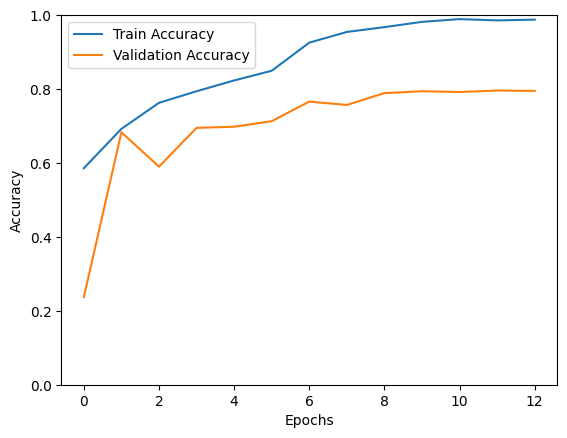

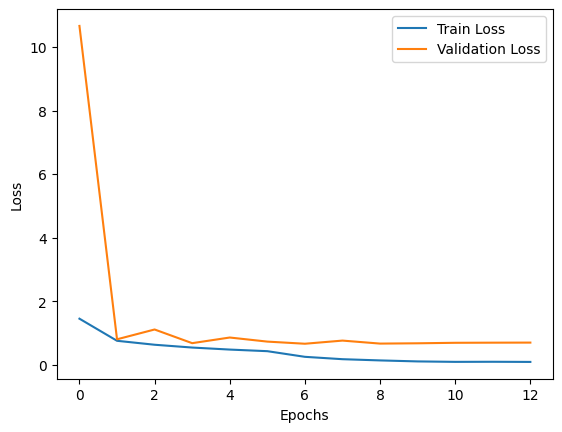

In [13]:
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)
plt.show()

# Graficar la pérdida
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Densenet


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.2, random_state=42, stratify=y_selected)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = tf.keras.applications.densenet.preprocess_input(X_train)
X_test = tf.keras.applications.densenet.preprocess_input(X_test)

# Ahora tus datos están listos para ser utilizados con ResNet
print(f"Tamaño de X_train: {X_train.shape}, Tipo: {X_train.dtype}")
print(f"Tamaño de X_test: {X_test.shape}, Tipo: {X_test.dtype}")

In [ ]:
y_train = y_train - 1
y_train = tf.keras.utils.to_categorical(y_train)
y_test = y_test - 1
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose = 1)
callback_reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
callbacks = [callback_es, callback_reduce_lr]

In [ ]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Regularización
x = Dense(256, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[callbacks]
)

In [ ]:
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Reducir la tasa de aprendizaje
model.compile(optimizer=Adam(learning_rate=1e-2),  # Tasa baja para fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenamiento con Fine-Tuning
history_finetune = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,  # Menos épocas
    batch_size=32,
    class_weight=class_weights
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.2, random_state=42, stratify=y_selected)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = tf.keras.applications.resnet.preprocess_input(X_train)
X_test = tf.keras.applications.resnet.preprocess_input(X_test)

# Ahora tus datos están listos para ser utilizados con ResNet
print(f"Tamaño de X_train: {X_train.shape}, Tipo: {X_train.dtype}")
print(f"Tamaño de X_test: {X_test.shape}, Tipo: {X_test.dtype}")

Tamaño de X_train: (3200, 224, 224, 3), Tipo: float32
Tamaño de X_test: (800, 224, 224, 3), Tipo: float32


In [ ]:
y_train = y_train - 1
y_train = tf.keras.utils.to_categorical(y_train)
y_test = y_test - 1
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
from keras.applications.resnet50 import ResNet50

image_input = Input(shape=(224, 224, 3))

m_Resnet50 = ResNet50(input_tensor=image_input, include_top=False,weights='imagenet')

m_Resnet50.summary()

last_layer = m_Resnet50.layers[-1].output

x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu', name='fc2')(x)
x=Dropout(0.3)(x)
out = Dense(5, activation='softmax', name='output')(x)
custom_model = Model(image_input, out)
custom_model.summary()

# freeze all the layers except the dense layers
for layer in custom_model.layers[:-6]:
    layer.trainable = False


custom_model.summary()

custom_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 220, 220, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 216, 216, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 108, 108, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 106, 106, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 104, 104, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 102, 102, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 51, 51, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 166464)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │      10,653,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,776,421 (41.11 MB)

 Trainable params: 10,776,421 (41.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=20,verbose=1, batch_size=32,validation_data=(X_test, y_test), callbacks=[callbacks])

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 150ms/step - accuracy: 0.3007 - loss: 1004.2278 - val_accuracy: 0.3950 - val_loss: 18.1940 - learning_rate: 0.0010
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - accuracy: 0.4856 - loss: 9.4011 - val_accuracy: 0.5325 - val_loss: 5.6596 - learning_rate: 0.0010
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.6353 - loss: 2.6888 - val_accuracy: 0.5688 - val_loss: 2.7151 - learning_rate: 0.0010
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.7192 - loss: 1.3545 - val_accuracy: 0.5913 - val_loss: 2.6104 - learning_rate: 0.0010
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.7138 - loss: 1.2259 - val_accuracy: 0.5950 - val_loss: 2.3985 - learning_rate: 0.0010
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.8383 - loss: 0.4436 - val_accuracy: 0.5987 - val_loss: 2.0191 - learning_rate: 0.0010
Epoch 6: early stopping
